In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import GenBank
from Bio.Graphics import GenomeDiagram
from reportlab.lib import colors
%matplotlib inline

In [2]:
# this analysis takes a set of strains and identifies genes unique to each strain
!head comparison_strains.txt

pseudomonas_sp_pseudo5_n2c3
pseudomonas_sp_wcs365
pseudomonas_sp_pseudo6_fw300_n2e2
pseudomonas_brassicacearum_subsp_brassicacearum_nfm421


In [3]:
strains = [line.rstrip() for line in open("comparison_strains.txt",'r').readlines()]

In [4]:
# first calculate genome similarity by taking the correlation coefficient of gene presence/absence matrix

infile = open("../data/Pseudo/homolog_matrix.txt",'r')
header_line = infile.readline().rstrip().split("\t")
indices = [header_line.index(s) for s in strains]

lines = []
groups = []
for line in infile:
    vals = line.rstrip().split("\t")
    # convert input data into boolean presence/absence
    lines.append([int(bool(int(vals[i]))) for i in indices])
    groups.append(vals[0])
a = np.stack(lines)
cc = np.corrcoef(a.T)
o = open("comparison.corrcoef.txt",'w')
o.write("\t{}\n".format("\t".join(strains)))
for i in range(0,len(strains)):
    o.write("{}\t{}\n".format(strains[i],"\t".join([str(x) for x in cc[i]])))
o.close()


In [5]:
cc

array([[ 1.        ,  0.8456383 ,  0.85180482,  0.84011166],
       [ 0.8456383 ,  1.        ,  0.84184401,  0.92112386],
       [ 0.85180482,  0.84184401,  1.        ,  0.83549347],
       [ 0.84011166,  0.92112386,  0.83549347,  1.        ]])

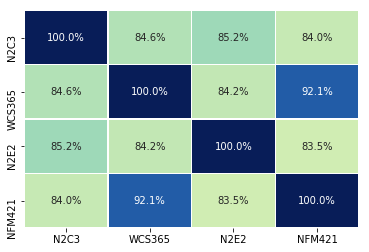

In [6]:
# use seaborn's heatmap to plot a genome similarity matrix
labels = ["N2C3","WCS365","N2E2","NFM421"]
sns.heatmap(cc, annot=True,vmin=0.80,vmax=0.96,linewidths=.5,
            xticklabels=labels,fmt=".1%",yticklabels=labels,cmap="YlGnBu",cbar=False)
plt.savefig("comparison_corrcoef.pdf",format="pdf")
plt.show()

In [7]:
# iterate through the matrix and find genes which are unique to each strain or uniquely missing from each strain
unique = {}
missing = {}
common = []
for s in strains:
    unique[s] = []
    missing[s] = []
for i in range(0,a.shape[0]):
    nz = np.nonzero(a[i])
    if len(nz[0]) == 1:
        unique[strains[nz[0][0]]].append(groups[i])
    elif len(nz[0]) == len(strains)-1:
        missing[strains[np.nonzero(a[i] < 1)[0][0]]].append(groups[i])
    elif len(nz[0]) == len(strains):
        common.append(groups[i])
    else:
        pass
for s in strains:
    print s
    print "\t", len(unique[s]), "unique"
    print "\t", len(missing[s]), "missing"
print len(common), "common to all strains."

pseudomonas_sp_pseudo5_n2c3
	342 unique
	193 missing
pseudomonas_sp_wcs365
	94 unique
	124 missing
pseudomonas_sp_pseudo6_fw300_n2e2
	368 unique
	201 missing
pseudomonas_brassicacearum_subsp_brassicacearum_nfm421
	231 unique
	55 missing
4535 common to all strains.


In [8]:
## focusing in on strain N2C3
## what are the names of the loci uniquely found in this strain?

locusfile = open("../data/Pseudo/locustag_matrix.txt",'r')
header_line = locusfile.readline().rstrip().split("\t")
i = header_line.index("pseudomonas_sp_pseudo5_n2c3")

unique_loci = []
for line in locusfile:
    vals = line.rstrip().split("\t")
    if vals[0] in unique["pseudomonas_sp_pseudo5_n2c3"]:
        for x in vals[i].split(";"):
            unique_loci.append(x)


In [9]:
# using GenomeDiagram and a Genbank file, plot the presence of unique loci

parser = GenBank.FeatureParser()
fhandle = open("N2C3.gbk", 'r')
genbank_entry = parser.parse(fhandle)
fhandle.close()


gdd = GenomeDiagram.Diagram('N2C3.gbk')
gd_track_for_features = gdd.new_track(1, name="CDS",scale_smalltick_interval=100000)
gdfs = gd_track_for_features.new_set()
for feature in genbank_entry.features:
    if feature.type == 'CDS':
        feature.strand = 1
        ## many of N2C3's unique genes were found in one specific region, which is highlighted first
        if feature.qualifiers['locus_tag'][0] in sorted(unique_loci)[269:293]:
            gdfs.add_feature(feature, color=colors.HexColor("#DD261D"))
        ## then the other unique genes
        elif feature.qualifiers['locus_tag'][0] in unique_loci:
            gdfs.add_feature(feature, color=colors.HexColor("#DB8912"))
        ## and the remaining genes
        else:
            gdfs.add_feature(feature, color=colors.HexColor("#8DBC1B"))
gdd.draw(format='circular', orientation='landscape',tracklines=0, pagesize='A5', fragments=5, circular=1)
gdd.write('N2C3_unique.pdf', 'pdf')


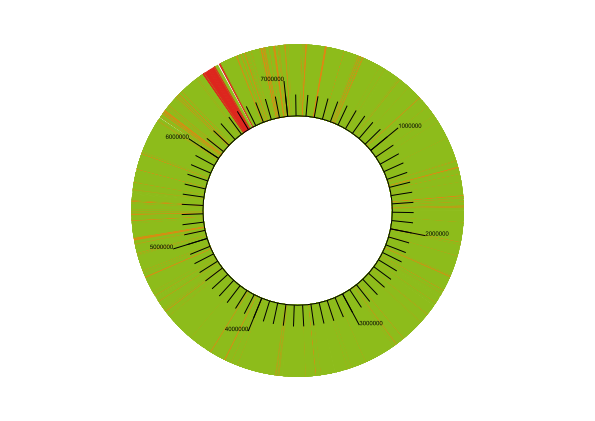

In [10]:
## since GenomeDiagram can't output inline :(  
## make a .png and reload it 
gdd.write('N2C3_unique.png', 'png')
from IPython.display import Image
Image(filename='N2C3_unique.png')